In [1]:
import os
import pickle
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms

In [ ]:
#====================>ResNet Model<=====================
class BasicBlock(nn.Module):
    expansion = 1
    # Workflow input->conv1->bn1->relu->conv2->bn2->add->relu return the final result
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super().__init__() 
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        identity = x
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        if self.downsample is not None:
            identity = self.downsample(x)
        out += identity
        out = F.relu(out)
        return out

In [ ]:
# ResNet Model with dynamic layers
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=10, in_channels=3,
                 initial_channels=64, channel_scaling=2):
        super().__init__()
        self.in_channels = initial_channels
        self.conv1 = nn.Conv2d(in_channels, self.in_channels, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(self.in_channels)
        self.relu = nn.ReLU(inplace=True)

        # Dynamically build layers which able to pass either 3 block layer or 4
        self.layers = nn.ModuleList()
        for i, num_blocks in enumerate(layers):
            out_channels = initial_channels * (channel_scaling ** i)
            stride = 2 if i > 0 else 1  # Downsample after the first layer
            layer = self._make_layer(block, out_channels, num_blocks, stride)
            self.layers.append(layer)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(initial_channels * (channel_scaling ** (len(layers) - 1)) * block.expansion, num_classes)

        # Weight initialization
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

     # create a residual layer with multiple basic blocks
    def _make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * block.expansion),
            )

        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        for layer in self.layers:
            x = layer(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x


In [ ]:
# ========================>data loading for training and testing<==========================
# Normalization stats for CIFAR-10 which compute from raw data at training dataset
data_statistics = ((0.4914, 0.4822, 0.4465), (0.2470, 0.2434, 0.2615))
def load_cifar_batch(file):
    with open(file, 'rb') as fo:
        dict_data = pickle.load(fo, encoding='bytes')
    return dict_data

# implement the data augumentation
def get_transforms():
    train_transform = transforms.Compose([
        transforms.RandomCrop(32, padding=4, padding_mode='reflect'),
        transforms.RandomHorizontalFlip(),
        transforms.RandomAdjustSharpness(sharpness_factor = 2,p = 0.2),
        transforms.ColorJitter(brightness = 0.1,contrast = 0.1,saturation = 0.1),
        transforms.GaussianBlur(kernel_size=(3,3)),
        transforms.ToTensor(),
        transforms.RandomRotation(10),
        transforms.RandomErasing(p=0.3, scale=(0.02, 0.15), value=1.0, inplace=False),
        transforms.Normalize(*data_statistics, inplace=True)
    ])
    test_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(*data_statistics, inplace=True)
    ])
    return train_transform, test_transform

# For Creating proper dataset
class CIFAR10CustomDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images  
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        img = Image.fromarray(self.images[index])
        label = self.labels[index]
        if self.transform:
            img = self.transform(img)
        return img, label

# get train and eval dataloaders
def get_train_and_eval_dataloaders(batch_size=128, data_dir='/kaggle/input/project1/deep-learning-spring-2025-project-1/cifar-10-python/cifar-10-batches-py/'):
    train_transform, test_transform = get_transforms()

    meta_data_dict = load_cifar_batch(os.path.join(data_dir, 'batches.meta'))
    label_names = meta_data_dict[b'label_names']  # e.g. b'airplane', b'automobile', etc.

    # Load training batches
    train_data_list = []
    train_labels = []
    for i in range(1, 6):
        batch_file = os.path.join(data_dir, f'data_batch_{i}')
        batch_dict = load_cifar_batch(batch_file)
        batch_data = batch_dict[b'data']
        batch_data = batch_data.reshape((10000, 3, 32, 32)).transpose(0, 2, 3, 1)
        train_data_list.append(batch_data)
        train_labels += batch_dict[b'labels']
    train_images = np.concatenate(train_data_list, axis=0)
    train_dataset = CIFAR10CustomDataset(train_images, train_labels, transform=train_transform)

    # Load validation batch
    test_batch = load_cifar_batch(os.path.join(data_dir, 'test_batch'))
    test_images = test_batch[b'data']
    test_images = test_images.reshape((10000, 3, 32, 32)).transpose(0, 2, 3, 1)
    test_labels = test_batch[b'labels']
    eval_dataset = CIFAR10CustomDataset(test_images, test_labels, transform=test_transform)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    eval_loader = DataLoader(eval_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

    return train_loader, eval_loader
  
  # find available GPUs, if not, using cpu
def get_default_device():
    return torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
#==================>Model Training <==================
# Training the model
def train_one_epoch(model, loader, criterion, optimizer, device, scheduler=None):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    avg_loss = running_loss / len(loader)
    accuracy = 100.0 * correct / total

    # Step the scheduler if it's not ReduceLROnPlateau
    if scheduler and not isinstance(scheduler, optim.lr_scheduler.ReduceLROnPlateau):
        scheduler.step()

    return avg_loss, accuracy

In [ ]:
# evaluate the model
def evaluate(model, loader, criterion, device, scheduler=None):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_loss = running_loss / len(loader)
    accuracy = 100.0 * correct / total

    return avg_loss, accuracy

In [ ]:
# Creating the ResNet model
def ResNetCustom(block_type=BasicBlock,num_classes=10, in_channels=3, initial_channels=32, channel_scaling=2, layers=None):
    if layers is None:
        layers = [2, 3, 3, 2]
    return ResNet(block_type, layers, num_classes=num_classes,
                  in_channels=in_channels, initial_channels=initial_channels,
                  channel_scaling=channel_scaling)

# function to implement different scheduler for user
def setup_scheduler(optimizer, scheduler_type, num_epochs):
    """
    Returns a learning rate scheduler based on the specified type.
    """
    if scheduler_type == "StepLR":
        return optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
    elif scheduler_type == "MultiStepLR":
        return optim.lr_scheduler.MultiStepLR(optimizer, milestones=[80,120], gamma=0.1)
    elif scheduler_type == "ExponentialLR":
        return optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
    elif scheduler_type == "CosineAnnealingLR":
        return optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
    elif scheduler_type == "ReduceLROnPlateau":
        return optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=10, threshold=0.001)
    else:
        return None


In [ ]:
#==================>help function <==================
# Loading unlabel image for testing
class TestDataset(Dataset):
    def __init__(self, images, transform=None):
        self.images = images
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        if self.transform:
            image = self.transform(image)
        return image, idx  # Return index as the image ID.
        
def load_custom_test_data(pkl_file, transform=None,batch_size=126):
    with open(pkl_file, 'rb') as f:
        data = pickle.load(f, encoding='bytes')
    print("Keys in custom test data:")  # Debug: print available keys
    
    images = data[b'data']
    test_dataset = TestDataset(images, transform=transform)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    return test_loader

# generate submission file (csv)
def generate_submission(model, loader, device, out_csv="submission.csv"):
    model.eval()
    all_ids = []
    all_preds = []
    with torch.no_grad():
        for images, ids in loader:
            images = images.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            # all_ids.extend(ids)  # IDs are typically strings/ints on CPU
            all_preds.extend(predicted.cpu().numpy().tolist())

    df = pd.DataFrame({"ID": range(len(all_preds)), "Labels": all_preds})
    df.to_csv(out_csv, index=False)
    print(f"Submission saved to {out_csv}")

# calculate total parameter
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# save checkpoint
def save_checkpoint(model, epoch, eval_acc, best_eval_acc, checkpoint_dir):
    if eval_acc > best_eval_acc:
        best_eval_acc = eval_acc
        checkpoint_path = os.path.join(checkpoint_dir, "model_best.pth")
        torch.save(model.state_dict(), checkpoint_path)
        print(f"Checkpoint saved at epoch {epoch+1} with Eval Acc: {eval_acc:.2f}%")
    return best_eval_acc

In [13]:
# def train_model(model, train_loader, eval_loader, device, criterion, optimizer, scheduler, num_epochs, checkpoint_dir):
#     """
#     Trains the model for a specified number of epochs. Evaluates on the validation set
#     and saves a checkpoint if there is an improvement.

#     Returns:
#         results (list): A list of tuples containing epoch number, train loss, train accuracy,
#                         evaluation loss, and evaluation accuracy.
#         best_eval_acc (float): The best evaluation accuracy achieved.
#     """
#     best_eval_acc = 0.0
#     results = []

#     for epoch in range(num_epochs):
#         train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device, scheduler)
#         eval_loss, eval_acc = evaluate(model, eval_loader, criterion, device, scheduler)
#         results.append((epoch + 1, train_loss, train_acc, eval_loss, eval_acc))
#         print(f"Epoch [{epoch+1}/{num_epochs}] - "
#               f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, "
#               f"Eval Loss: {eval_loss:.4f}, Eval Acc: {eval_acc:.2f}%")

#         # Save checkpoint if the current evaluation accuracy is the best so far
#         best_eval_acc = save_checkpoint(model, epoch, eval_acc, best_eval_acc, checkpoint_dir)

#     return results, best_eval_acc

In [14]:
# def train_model(model, train_loader, eval_loader, device, criterion, optimizer, scheduler, num_epochs, checkpoint_dir):
#     """
#     Trains the model for a specified number of epochs with a learning rate warm-up phase.
    
#     Returns:
#         results (list): A list of tuples containing epoch number, train loss, train accuracy,
#                         evaluation loss, and evaluation accuracy.
#         best_eval_acc (float): The best evaluation accuracy achieved.
#     """
#     best_eval_acc = 0.0
#     results = []
    
#     # Define warm-up parameters
#     warmup_epochs = 5  # Number of warm-up epochs
#     initial_lr = 0.01  # Start with lower learning rate
#     target_lr = 0.1  # Standard learning rate

#     for epoch in range(num_epochs):
#         # Apply warm-up for the first few epochs
#         if epoch < warmup_epochs:
#             new_lr = initial_lr + (target_lr - initial_lr) * (epoch / warmup_epochs)
#             for param_group in optimizer.param_groups:
#                 param_group['lr'] = new_lr
#             print(f"Warm-up Epoch [{epoch+1}/{warmup_epochs}] - Adjusted LR: {new_lr:.6f}")
#         elif scheduler is not None:
#             scheduler.step()  # Apply scheduler after warm-up
#             # scheduler.step(validation_metric)

#         # Train for one epoch
#         train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device, scheduler)
        
#         # Evaluate model
#         eval_loss, eval_acc = evaluate(model, eval_loader, criterion, device, scheduler)
        
#         results.append((epoch + 1, train_loss, train_acc, eval_loss, eval_acc))
        
#         print(f"Epoch [{epoch+1}/{num_epochs}] - "
#               f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, "
#               f"Eval Loss: {eval_loss:.4f}, Eval Acc: {eval_acc:.2f}%")

#         # Save checkpoint if the current evaluation accuracy is the best so far
#         best_eval_acc = save_checkpoint(model, epoch, eval_acc, best_eval_acc, checkpoint_dir)

#     return results, best_eval_acc


In [ ]:
# This is model with "warm-up" learning rate
# def train_model(model, train_loader, eval_loader, device, criterion, optimizer, scheduler, num_epochs, checkpoint_dir):
#     """
#     Trains the model for a specified number of epochs with a learning rate warm-up phase.
    
#     Returns:
#         results (list): A list of tuples containing epoch number, train loss, train accuracy,
#                         evaluation loss, and evaluation accuracy.
#         best_eval_acc (float): The best evaluation accuracy achieved.
#     """
#     best_eval_acc = 0.0
#     results = []
    
#     # Define warm-up parameters
#     warmup_epochs = 5  # Number of warm-up epochs
#     initial_lr = 0.01  # Start with lower learning rate
#     target_lr = 0.1  # Standard learning rate

#     for epoch in range(num_epochs):
#         # Apply learning rate warm-up
#         if epoch < warmup_epochs:
#             new_lr = initial_lr + (target_lr - initial_lr) * (epoch / warmup_epochs)
#             for param_group in optimizer.param_groups:
#                 param_group['lr'] = new_lr
#             print(f"Warm-up Epoch [{epoch+1}/{warmup_epochs}] - Adjusted LR: {new_lr:.6f}")

#         # Train for one epoch
#         train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)

#         # Evaluate model
#         eval_loss, eval_acc = evaluate(model, eval_loader, criterion, device)

#         # Apply learning rate scheduler **after** warm-up (if applicable)
#         if scheduler is not None and epoch >= warmup_epochs:
#             if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
#                 scheduler.step(eval_acc)  # ReduceLROnPlateau requires a monitored metric
#             else:
#                 scheduler.step()  # Step for other schedulers

#         # Save results for logging
#         results.append((epoch + 1, train_loss, train_acc, eval_loss, eval_acc))
        
#         print(f"Epoch [{epoch+1}/{num_epochs}] - "
#               f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, "
#               f"Eval Loss: {eval_loss:.4f}, Eval Acc: {eval_acc:.2f}%")

#         # Save checkpoint if evaluation accuracy improves
#         best_eval_acc = save_checkpoint(model, epoch, eval_acc, best_eval_acc, checkpoint_dir)

#     return results, best_eval_acc


In [ ]:
def train_model(model, train_loader, eval_loader, device, criterion, optimizer, scheduler, num_epochs, checkpoint_dir):
    best_eval_acc = 0.0
    results = []

    for epoch in range(num_epochs):
        train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device, scheduler)
        eval_loss, eval_acc = evaluate(model, eval_loader, criterion, device, scheduler)
        results.append((epoch + 1, train_loss, train_acc, eval_loss, eval_acc))
        print(f"Epoch [{epoch+1}/{num_epochs}] - "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, "
              f"Eval Loss: {eval_loss:.4f}, Eval Acc: {eval_acc:.2f}%")

        # Save checkpoint if the current evaluation accuracy is the best so far
        best_eval_acc = save_checkpoint(model, epoch, eval_acc, best_eval_acc, checkpoint_dir)

    return results, best_eval_acc

Using device: cuda
Using device: cuda
Total Parameters: 4682200
Epoch [1/150] - Train Loss: 2.3854, Train Acc: 12.07%, Eval Loss: 2.2411, Eval Acc: 14.89%
Checkpoint saved at epoch 1 with Eval Acc: 14.89%
Epoch [2/150] - Train Loss: 1.9016, Train Acc: 27.92%, Eval Loss: 1.7441, Eval Acc: 34.79%
Checkpoint saved at epoch 2 with Eval Acc: 34.79%
Epoch [3/150] - Train Loss: 1.6209, Train Acc: 39.52%, Eval Loss: 1.4349, Eval Acc: 45.91%
Checkpoint saved at epoch 3 with Eval Acc: 45.91%
Epoch [4/150] - Train Loss: 1.4245, Train Acc: 47.93%, Eval Loss: 1.4329, Eval Acc: 47.96%
Checkpoint saved at epoch 4 with Eval Acc: 47.96%
Epoch [5/150] - Train Loss: 1.2433, Train Acc: 55.17%, Eval Loss: 1.2204, Eval Acc: 56.74%
Checkpoint saved at epoch 5 with Eval Acc: 56.74%
Epoch [6/150] - Train Loss: 1.1034, Train Acc: 60.56%, Eval Loss: 1.0302, Eval Acc: 63.21%
Checkpoint saved at epoch 6 with Eval Acc: 63.21%
Epoch [7/150] - Train Loss: 0.9947, Train Acc: 64.82%, Eval Loss: 0.9908, Eval Acc: 65.23%

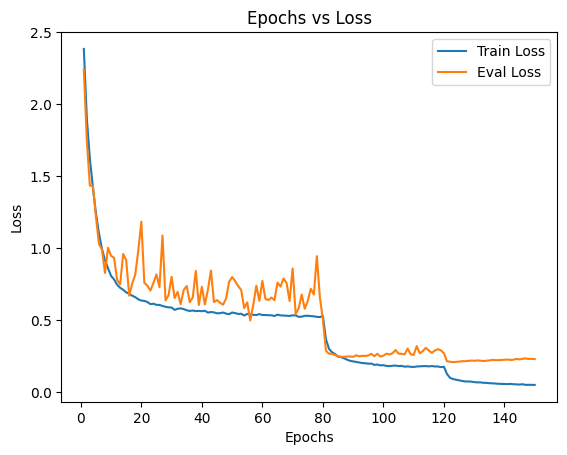

Keys in custom test data:
Submission saved to submission.csv


In [ ]:
def main():
    num_epochs = 150  
    batch_size = 256
    results = []
    device = get_default_device()
    data_dir="/kaggle/input/project1/deep-learning-spring-2025-project-1/cifar-10-python/cifar-10-batches-py"
    checkpoint_dir = "/kaggle/working"
    os.makedirs(checkpoint_dir, exist_ok=True)
    print("Using device:", device)

    train_loader, eval_loader = get_train_and_eval_dataloaders(batch_size, data_dir)
    # Device and data loaders setup
    device = get_default_device()
    print("Using device:", device)
    train_loader, eval_loader = get_train_and_eval_dataloaders(batch_size, data_dir)

    # Model initialization and configuration
    model = ResNetCustom(block_type=BasicBlock, layers=[3,4,6,3], initial_channels=30).to(device)
    if device.type == 'cuda':
        model = torch.nn.DataParallel(model)

    # Loss, optimizer, and scheduler setup
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-3,nesterov=True,foreach=True)
    scheduler_type = "MultiStepLR" 
    scheduler = setup_scheduler(optimizer, scheduler_type, num_epochs)

    # Check model parameter count
    if count_parameters(model) > 5000000:
        print("Model has too many parameters:", count_parameters(model))
        return
    print("Total Parameters:", count_parameters(model))

    # Train the model and save checkpoints when improvements occur
    results, best_eval_acc = train_model(model, train_loader, eval_loader, device, criterion, optimizer, scheduler, num_epochs, checkpoint_dir)

    # Save training history and generate plots
    df = pd.DataFrame(results, columns=['Epoch', 'Train Loss', 'Train Acc', 'Eval Loss', 'Eval Acc'])
    df.to_csv('/kaggle/working/layer2[6,6,6]_with_weight_decay_epoch_vs_loss.csv', index=False)
    df.plot(x='Epoch', y=['Train Loss', 'Eval Loss'], title='Epochs vs Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.savefig('epoch_vs_loss.png')
    plt.show()

    # Save model
    torch.save(model.state_dict(), 'model_final.pth')
    custom_test_file = "/kaggle/input/project1/deep-learning-spring-2025-project-1/cifar_test_nolabel.pkl"
    _, test_transform = get_transforms()
    custom_test_loader = load_custom_test_data(custom_test_file, transform=test_transform, batch_size=batch_size)

    generate_submission(model, custom_test_loader, device, out_csv="submission.csv")


if __name__ == "__main__":
    main()